# Imports and helpers

In [12]:
import sys
sys.path.append('..')

In [13]:
import numpy as np
import torch
import torchvision
from torchvision import transforms as pth_transforms
import torch.nn.functional as F
import PIL
from PIL import Image
# from statistics_incontext_learning_utils import *

In [14]:
print(torch.__version__)
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

2.4.1


In [15]:
to_tensor_if_needed = lambda x: pth_transforms.ToTensor()(x) if not isinstance(x, torch.Tensor) else x
to_pil_if_needed = lambda x: pth_transforms.ToPILImage()(x) if isinstance(x, torch.Tensor) else x

imagenet_normalize = pth_transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
imagenet_unnormalize = lambda x: x*torch.Tensor([0.229, 0.224, 0.225])[None, :, None, None] + torch.Tensor([0.485, 0.456, 0.406])[None, :, None, None]

In [16]:
def hconcat_pil_images(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  return new_im

def vconcat_pil_images(images):
  widths, heights = zip(*(i.size for i in images))

  max_width = max(widths)
  total_height = sum(heights)

  new_im = Image.new('RGB', (max_width, total_height))

  y_offset = 0
  for im in images:
    new_im.paste(im, (0,y_offset))
    y_offset += im.size[1]

  return new_im

def plot_images(*im):
  im = [to_pil_if_needed(x) for x in im]
  plot_im = hconcat_pil_images(im)
  display(plot_im)
  # return plot_im

# Models

## DINO

In [17]:
sys.path.append('../dino')
import vision_transformer as vits

def load_dino_model(pretrained_weights=None, arch='vit_small'):
  patch_size = 16
  model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
  model.apply(model._init_weights)
  model.patch_size = patch_size

  if pretrained_weights is None:
    state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth")
  elif pretrained_weights == 'random':
    state_dict = None
  else:
    state_dict = torch.load(pretrained_weights, map_location="cpu")['teacher']

  for p in model.parameters():
      p.requires_grad = False
  model.eval()

  if state_dict is not None:
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

    # model.to(device)
    msg = model.load_state_dict(state_dict, strict=False)
    # print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

  model.eval()
  return model.to(device)

In [ ]:
dino_models_dict = {
    'random':{'pretrained_weights':'random'},
    'stylegan':{'pretrained_weights':'../dino/encoders/stylegan-oriented-512/checkpoint.pth'},
    'shaders':{'pretrained_weights':f'../dino/encoders/shaders/checkpoint.pth'},
    #'shaders_mixup':{'pretrained_weights':f'../dino/encoders/shaders_mixup/checkpoint.pth'},
    "shaders_kml":{'pretrained_weights':f'../dino/encoders/shaders_kml/checkpoint.pth'},
    #"shaders_kml_mixup":{'pretrained_weights':f'../dino/encoders/shaders_kml_mixup/checkpoint.pth'},
    'places':{'pretrained_weights':f'../dino/encoders/places/checkpoint.pth'},
    'imagenet':{'pretrained_weights':f'../dino/encoders/imagenet/checkpoint.pth'},
}

# dino_model = load_dino_model(dino_models_dict['random']['pretrained_weights'])
# dino_model = load_dino_model(dino_models_dict['stylegan']['pretrained_weights'])
# dino_model = load_dino_model(dino_models_dict['shaders']['pretrained_weights'])
dino_model = load_dino_model(dino_models_dict['shaders_kml']['pretrained_weights'])
# dino_model = load_dino_model(dino_models_dict['places']['pretrained_weights'])
# dino_model = load_dino_model(dino_models_dict['imagenet']['pretrained_weights'])

/tmp/ipykernel_3263604/3172311044.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_weights, map_location="cpu")['teacher']


In [19]:
import torch.nn as nn

def dino_encode(dino_model, image_tensor):
  patch_size = dino_model.patch_size
  height, width = image_tensor.shape[1:]
  grid_size = (height // patch_size, width // patch_size)

  with torch.inference_mode():
      image_batch = image_tensor.unsqueeze(0)
      image_batch = imagenet_normalize(image_batch)
      tokens = dino_model.get_intermediate_layers(image_batch)[0].squeeze()
      # tokens = nn.functional.normalize(tokens, dim=-1, p=2)
      class_token = tokens[0]
      tokens = tokens[1:]

  array = tokens #.numpy()
  array = array.reshape(*grid_size, tokens.shape[-1])
  array = array.permute(2, 0, 1)
  # array = pth_transforms.Resize((image.width, image.height), interpolation=2)(array)
  array = array.permute(1, 2, 0)

  return class_token, array

# Datasets

## Load PASCAL segmentation

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
    #                      std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Mask transformations
mask_transforms = transforms.Compose([
    transforms.Resize((28, 28), interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.Resize((14, 14), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()  # Returns mask as ByteTensor
])

In [22]:
# Initialize the VOCSegmentation dataset
dataset = VOCSegmentation(
    root='../data/pascal2012',  # Replace with your desired directory
    year='2012',
    image_set='train',                   # Options: 'train', 'trainval', 'val', 'test'
    download=False,                       # Downloads the dataset if not present
    transform=image_transforms,
    target_transform=mask_transforms
)

test_dataset = VOCSegmentation(
    root='../data/pascal2012',  # Replace with your desired directory
    year='2012',
    image_set='val',                   # Options: 'train', 'trainval', 'val', 'test'
    download=False,                       # Downloads the dataset if not present
    transform=image_transforms,
    target_transform=mask_transforms
)

In [23]:
# Create DataLoader
torch.manual_seed(0)
batch_size = 4
num_workers = 2

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [24]:
# Fetch a single batch
images, masks = next(iter(train_loader))
masks = masks.squeeze(1).long()

In [25]:
masks.shape

torch.Size([4, 28, 28])

In [26]:
np.unique(masks[3])

array([  0,  12,  15,  18, 255])

### Visualize

In [27]:
def visualize_batch(images, masks, class_names=None):
    """
    Visualize a batch of images and their corresponding masks.

    Args:
        images (Tensor): Batch of images [B, 3, H, W]
        masks (Tensor): Batch of masks [B, H, W]
        class_names (list, optional): List of class names for coloring.
    """
    batch_size = images.size(0)
    images = images.numpy().transpose(0, 2, 3, 1)  # [B, H, W, C]
    # images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    images = np.clip(images, 0, 1)

    masks = masks.numpy()
    masks[masks==255] = 0

    # Define a color palette (optional)
    # Here, we use a simple palette with random colors for demonstration
    if class_names is None:
        unique_classes = np.unique(masks)
        colors = plt.cm.get_cmap('tab20', 21)  # 21 classes
    else:
        colors = plt.cm.get_cmap('tab20', len(class_names))

    plt.figure(figsize=(3*batch_size, 6))
    for i in range(batch_size):
        plt.subplot(2, batch_size, i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        plt.subplot(2, batch_size, batch_size + i + 1)
        plt.imshow(masks[i], cmap='tab20', vmin=0, vmax=20)
        # plt.imshow(masks[i], cmap=colors)
        plt.title(f'Mask {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3263604/667468177.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # 21 classes


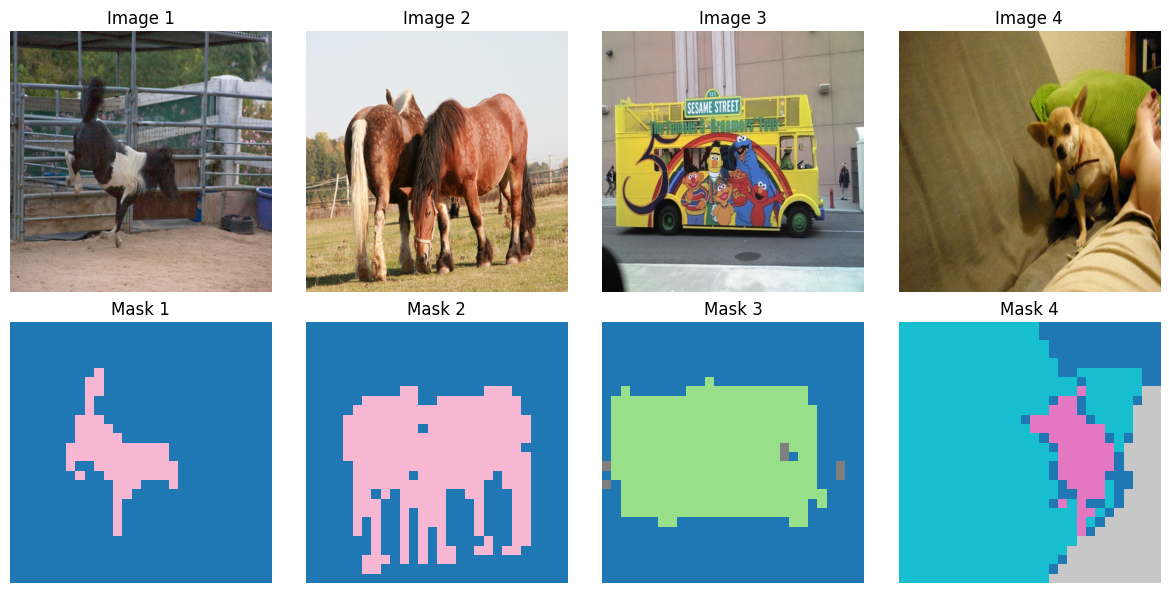

In [28]:
# Visualize the batch
visualize_batch(images, masks)

## Algorithms

In [29]:
def mask_to_onehot(mask):
  return F.one_hot(mask, num_classes=21)

def onehot_to_mask(pred):
  return pred.argmax(-1)


In [30]:
# Define the 21-color palette
pascal_voc_palette = [
    (0, 0, 0),         # 0=Background
    (128, 0, 0),       # 1=Aeroplane
    (0, 128, 0),       # 2=Bicycle
    (128, 128, 0),     # 3=Bird
    (0, 0, 128),       # 4=Boat
    (128, 0, 128),     # 5=Bottle
    (0, 128, 128),     # 6=Bus
    (128, 128, 128),   # 7=Car
    (64, 0, 0),        # 8=Cat
    (192, 0, 0),       # 9=Chair
    (64, 128, 0),      # 10=Cow
    (192, 128, 0),     # 11=Dining Table
    (64, 0, 128),      # 12=Dog
    (192, 0, 128),     # 13=Horse
    (64, 128, 128),    # 14=Motorbike
    (192, 128, 128),   # 15=Person
    (0, 64, 0),        # 16=Potted Plant
    (128, 64, 0),      # 17=Sheep
    (0, 192, 0),        # 18=Sofa
    (128, 192, 0),      # 19=Train
    (0, 64, 128)        # 20=TV/Monitor
]

# Convert the palette to a tensor
palette_tensor = torch.tensor(pascal_voc_palette, dtype=torch.uint8)

def mask_to_rgb_pytorch(mask, colormap=palette_tensor):
    """
    Convert an integer mask to an RGB image using a specified colormap.

    Args:
        mask (torch.Tensor): 2D tensor with integer class labels (shape: [H, W]).
        colormap (list or torch.Tensor): List of RGB tuples or a tensor (length: 21).

    Returns:
        torch.Tensor: 3D tensor representing the RGB image (shape: [3, H, W]).
    """
    if not isinstance(mask, torch.Tensor):
        raise TypeError("Mask must be a PyTorch tensor.")
    
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D tensor.")
    
    if len(colormap) != 21:
        raise ValueError("Colormap must have 21 colors.")
    
    # Convert colormap to a tensor if it's a list
    if isinstance(colormap, list):
        colormap = torch.tensor(colormap, dtype=torch.uint8, device=mask.device)  # [21, 3]
    elif isinstance(colormap, torch.Tensor):
        if colormap.shape != (21, 3):
            raise ValueError("Colormap tensor must have shape [21, 3].")
        colormap = colormap.to(mask.device)
    else:
        raise TypeError("Colormap must be a list or a torch.Tensor.")
    
    # Map each class index to its RGB color
    rgb_image = colormap[mask]  # [H, W, 3]
    
    # Permute to [3, H, W] for PyTorch convention
    rgb_image = rgb_image.permute(2, 0, 1).contiguous()  # [3, H, W]
    
    return rgb_image

## Large scale

In [31]:
def dino_encode_batch(dino_model, image_tensor):
  patch_size = dino_model.patch_size
  height, width = image_tensor.shape[-2:]
  grid_size = (height // patch_size, width // patch_size)

  with torch.inference_mode():
      image_batch = image_tensor #.unsqueeze(0)
      image_batch = imagenet_normalize(image_batch)
      tokens = torch.concat([dino_model.get_intermediate_layers(image_batch[i:i+256])[0] for i in range(0, image_batch.shape[0], 256)]) #.squeeze()
      # tokens = nn.functional.normalize(tokens, dim=-1, p=2)
      class_token = tokens[:, 0]
      tokens = tokens[:, 1:]

  array = tokens #.numpy()
  array = array.reshape(image_tensor.shape[0], *grid_size, tokens.shape[-1])
  # array = array.permute(2, 0, 1)
  # array = pth_transforms.Resize((image.width, image.height), interpolation=2)(array)
  # array = array.permute(0, 3, 1, 2)

  return class_token, array

In [32]:
import numpy as np
import scipy

# def xattn_batch(q, k, v):
#   q, k, v = q.clone(), k.clone(), v.clone()
#   print(q.shape, k.shape, v.shape)
  
#   B, N, C = q.shape
#   assert q.shape[-1] == k.shape[-1]
#   assert k.shape[:-1] == v.shape[:-1]

#   k = k.view(1, k.shape[0]*k.shape[1], k.shape[2])
#   v = v.view(1, v.shape[0]*v.shape[1], v.shape[2])

#   # q, k, v = q.numpy(), k.numpy(), v.numpy()

#   w = (q[:, :, None, :] * k[:, None, :, :]).sum(-1) / C
#   #w = np.tensordot(q[:, :, None, :], k[:, :, None, :], axes=((3,), (3,))) / C
#   attn = w.softmax(2)
#   # attn = scipy.special.softmax(w, 2)
#   out = (attn[:, :, :, None] * v[:, None, :, :]).sum(2)
#   # out = np.tensordot(attn[:, :, :, None], v[:, None, :, :], axes=((2,), (2,)))

#   print(out.shape)
#   #out = torch.from_numpy(out)
#   return out.detach()

def binarize_kth_largest(tensor, k, dim):
  # Get the kth largest element along dimension `dim`
  # We use `k` here because `topk` returns the top `k` values, so the last value in this selection is the k-th largest
  kth_largest, _ = torch.topk(tensor, k=k, dim=dim)
  
  # Extract the k-th largest value along the chosen dimension
  kth_value = kth_largest.select(dim, k-1).unsqueeze(dim)
  
  # Binarize the tensor using the k-th largest element as the threshold
  binarized_tensor = (tensor >= kth_value).float()
  
  return binarized_tensor

# @torch.jit.script
def xattn_batch(q, k, v):
  k = k.view(1, k.shape[0]*k.shape[1], k.shape[2])
  v = v.view(1, v.shape[0]*v.shape[1], v.shape[2])
  #q, k, v = q.numpy(), k.numpy(), v.numpy()

  # w = (q[:, :, None, :] * k[:, None, :, :]).sum(-1) / q.shape[-1]
  w = torch.einsum("qxc,kyc->qxy", q, k)
  # w = w / q.shape[-1]**1
  w = w / q.shape[-1]**0.5
  attn = w.softmax(2)
  # attn = binarize_kth_largest(w, 5, 2) / 5
  #attn = scipy.special.softmax(w, 2)
  # out = (attn[:, :, :, None] * v[:, None, :, :]).sum(2)
  out = torch.einsum("qxy,kyc->qxc", attn, v.float())

  # out = torch.from_numpy(out)
  return out

In [33]:
def xattn_incontext_batch(xqs, xks, yks):
  torch.cuda.empty_cache() 
  xqs, xks = xqs.to(device), xks.to(device)

  _, dino_features_xq = dino_encode_batch(dino_model, xqs)
  dino_features_xq = dino_features_xq.to('cpu').flatten(1,2) #.unsqueeze(0)

  _, dino_features_xk = dino_encode_batch(dino_model, xks)
  dino_features_xk = dino_features_xk.to('cpu').flatten(1,2) #.unsqueeze(0)

  onehot_labels_yk = mask_to_onehot(yks).flatten(1, 2) #.unsqueeze(0)

  onehot_labels_yq = torch.concat([xattn_batch(dino_features_xq_i.unsqueeze(0), dino_features_xk, onehot_labels_yk) for dino_features_xq_i in dino_features_xq])
  yq = onehot_to_mask(onehot_labels_yq).view(xqs.shape[0], *yks.shape[1:])
  return yq

In [34]:
# Create DataLoader
torch.manual_seed(0)
batch_size = 512
num_workers = 2

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

In [35]:
# Fetch a single batch
train_images, train_masks = next(iter(train_loader))
train_masks = train_masks.squeeze(1).long()
train_masks[train_masks == 255] = 0

In [36]:
test_images, test_masks = next(iter(test_loader))
test_masks = test_masks.squeeze(1).long()
test_masks[test_masks == 255] = 0

/tmp/ipykernel_3263604/667468177.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # 21 classes


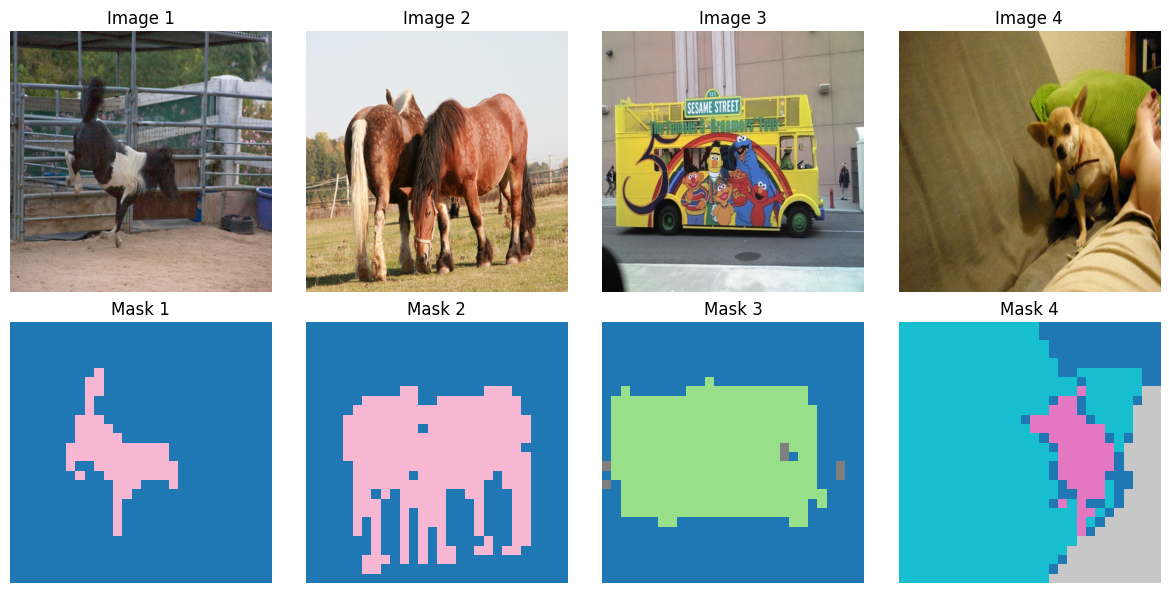

In [37]:
visualize_batch(train_images[:4], train_masks[:4])

/tmp/ipykernel_3263604/667468177.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # 21 classes


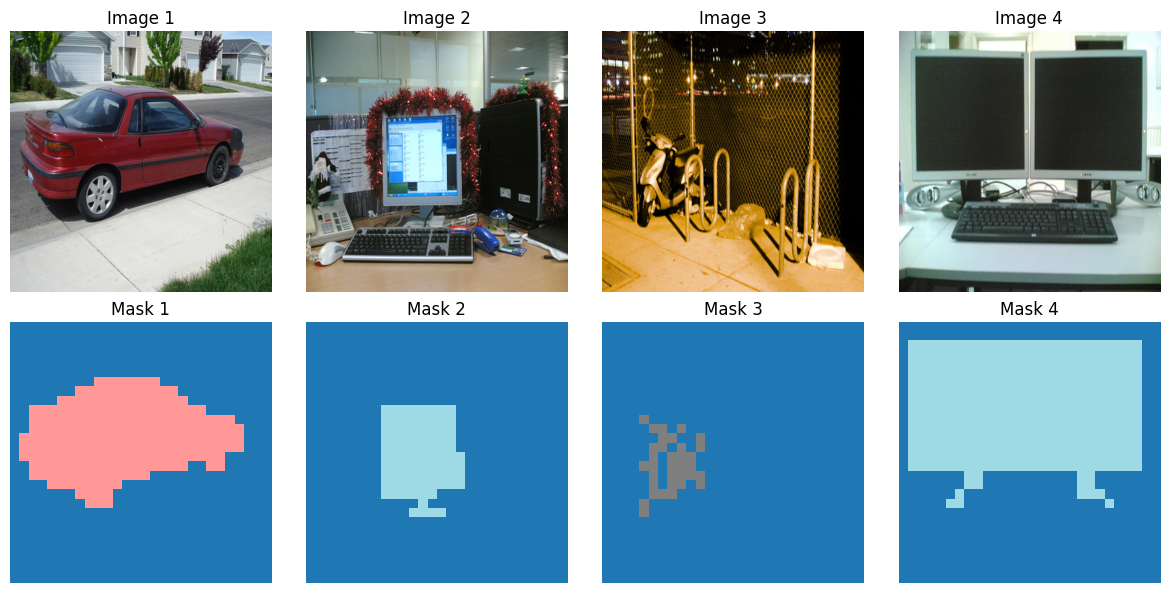

In [38]:
visualize_batch(train_images[4:8], train_masks[4:8])

/tmp/ipykernel_3263604/667468177.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # 21 classes


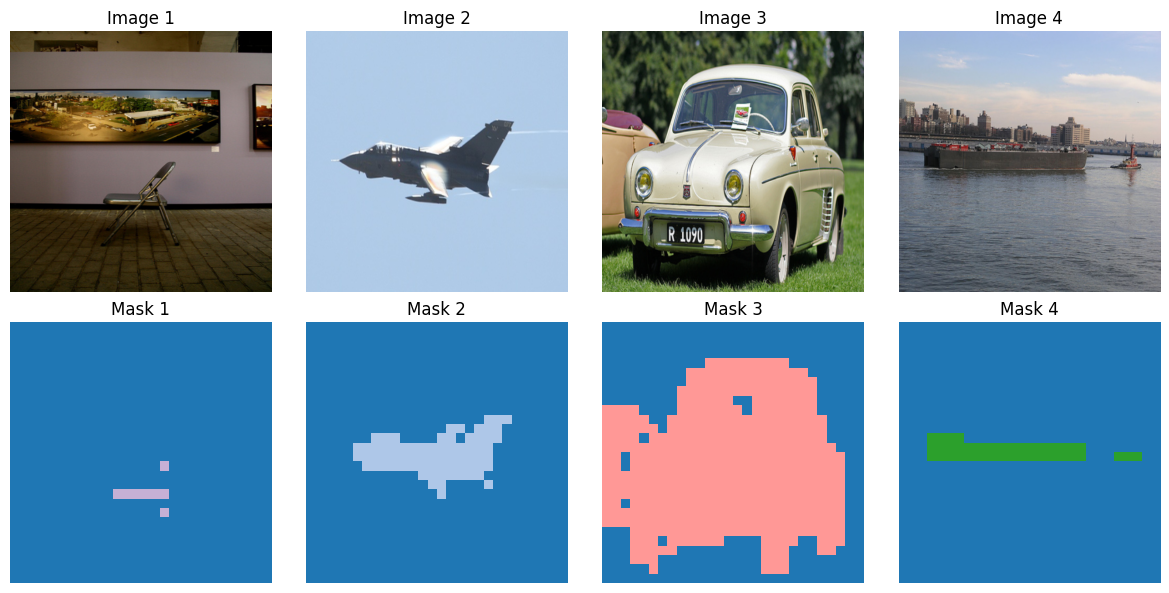

In [39]:
visualize_batch(test_images[:4], test_masks[:4])

In [40]:
with torch.no_grad():
  pred = xattn_incontext_batch(test_images, train_images, train_masks)

/tmp/ipykernel_3263604/667468177.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # 21 classes


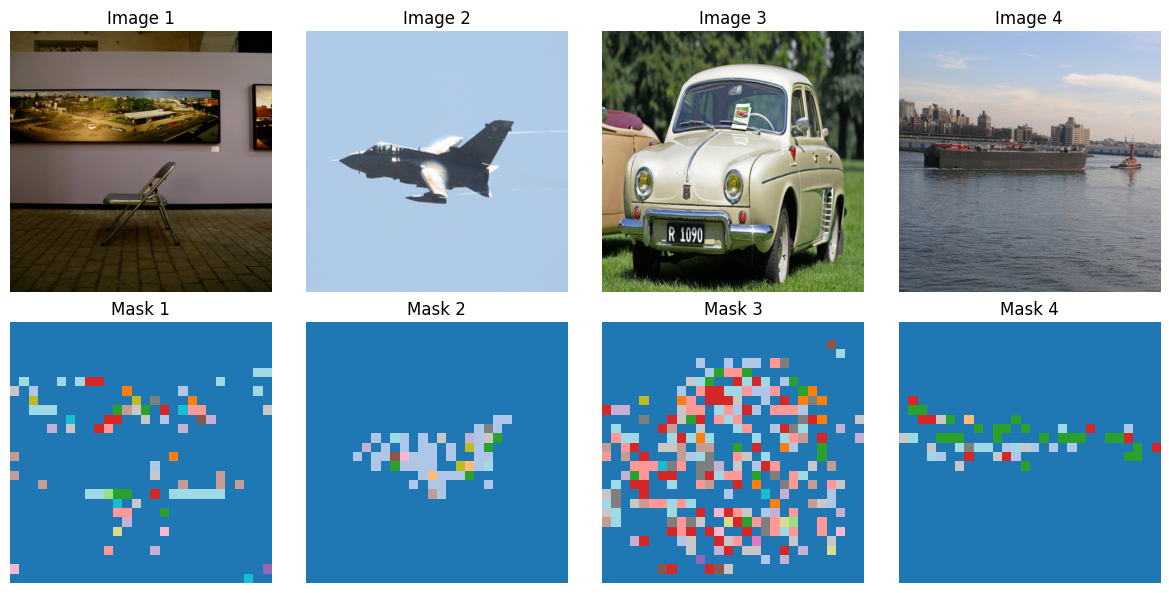

In [41]:
visualize_batch(test_images[:4], pred[:4])

In [42]:
(pred == test_masks).float().mean(), (pred[test_masks > 0] == test_masks[test_masks > 0]).float().mean()

(tensor(0.8064), tensor(0.1536))

- fast2leaves: (tensor(0.8080), tensor(0.1607))
- places: (tensor(0.8938), tensor(0.5536))